# MSA 2023
https://github.com/xylarshayu

---

1. MELD - Dataset that's been used. https://github.com/declare-lab/MELD
2. Previous attempt (along with data analysis on dataset): https://colab.research.google.com/drive/1MYaJZZshcTsmVipJCqeHbdDpmX59QfmG?usp=sharing
3. 


## Some knobs and dials for the notebook

In [1]:
DOWNLOAD_DATASET_FROM_SOURCE = False # Downloading the entire dataset from original source instead of just zip file from my drive


## Getting the Dataset

In [2]:
!pip install gdown transformers tqdm speechbrain optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.6 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.1/757.1 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 102.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.8 MB/s eta 0:00:00

In [2]:
import os
import requests
import tarfile
import shutil
import zipfile
import gdown
import subprocess

In [4]:
def download_and_extract_meld_dataset():
  subprocess.run(["wget", "https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz"])

  subprocess.run(["tar", "-xzvpf", "MELD.Raw.tar.gz", "-C", "."])
  subprocess.run(["tar", "-xzvf", "MELD.Raw/dev.tar.gz", "-C", "MELD.Raw/"])
  subprocess.run(["tar", "-xzvf", "MELD.Raw/test.tar.gz", "-C", "MELD.Raw/"])
  subprocess.run(["tar", "-xzvf", "MELD.Raw/train.tar.gz", "-C", "MELD.Raw/"])

  subprocess.run(["rm", "MELD.Raw.tar.gz"])
  subprocess.run(["rm", "MELD.Raw/dev.tar.gz"])
  subprocess.run(["rm", "MELD.Raw/test.tar.gz"])
  subprocess.run(["rm", "MELD.Raw/train.tar.gz"])

def download_meld_zip():
  url = "https://drive.google.com/uc?id=11vTa_5JYNQmwM9F4dPXHMFBFoFXsRYfC"
  gdown.download(url, output="MELD.Raw.zip", quiet=False)
  meld_zip_file = "MELD.Raw.zip"
  with zipfile.ZipFile(meld_zip_file, 'r') as zip_ref:
      zip_ref.extractall()
  shutil.move("content/MELD.Raw", ".")
  os.remove(meld_zip_file)
  shutil.rmtree("content")

# Check if the MELD dataset already exists in the current directory
if not os.path.isdir("MELD.Raw"):
    download_and_extract_meld_dataset() if DOWNLOAD_DATASET_FROM_SOURCE else download_meld_zip()


Downloading...
From (uriginal): https://drive.google.com/uc?id=11vTa_5JYNQmwM9F4dPXHMFBFoFXsRYfC
From (redirected): https://drive.google.com/uc?id=11vTa_5JYNQmwM9F4dPXHMFBFoFXsRYfC&confirm=t&uuid=349836c4-0cfe-4a2f-a07b-c09cbb24c36b
To: /home/jupyter/MELD.Raw.zip
100%|██████████| 10.9G/10.9G [00:43<00:00, 251MB/s]


## Data Preperation

1. Importing CSV files
2. Converting audio to embeddings using SpeechBrain
3. Converting Text to embeddings using BERT
4. Saving these neatly to drive as checkpoints

In [19]:
!pip uninstall torch torchvision torchaudio -y
!pip install --no-cache-dir torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Found existing installation: torch 1.10.0+cu113
Uninstalling torch-1.10.0+cu113:
  Successfully uninstalled torch-1.10.0+cu113
Found existing installation: torchvision 0.11.1+cu113
Uninstalling torchvision-0.11.1+cu113:
  Successfully uninstalled torchvision-0.11.1+cu113
Found existing installation: torchaudio 0.10.0+cu113
Uninstalling torchaudio-0.10.0+cu113:
  Successfully uninstalled torchaudio-0.10.0+cu113
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 34.1 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 758.6 kB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import datetime
import math
from tqdm import tqdm
import sys
import multiprocessing
from transformers import BertTokenizer
from speechbrain.pretrained import EncoderClassifier
from concurrent.futures import ProcessPoolExecutor
from sklearn.preprocessing import LabelEncoder

num_cores = multiprocessing.cpu_count()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
SB_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")

### Importing csv files

In [3]:
train_df = pd.read_csv('MELD.Raw/train_sent_emo.csv')
dev_df = pd.read_csv('MELD.Raw/dev_sent_emo.csv')
test_df = pd.read_csv('MELD.Raw/test_sent_emo.csv')

In [4]:
#@title Remove all rows where the duration is greater than 5 seconds
train_df['StartTime'] = pd.to_datetime(train_df['StartTime'])
train_df['EndTime'] = pd.to_datetime(train_df['EndTime'])
test_df['StartTime'] = pd.to_datetime(test_df['StartTime'])
test_df['EndTime'] = pd.to_datetime(test_df['EndTime'])
dev_df['StartTime'] = pd.to_datetime(dev_df['StartTime'])
dev_df['EndTime'] = pd.to_datetime(dev_df['EndTime'])

# Calculate the duration of each utterance as the difference between the 'EndTime' and 'StartTime' values
train_df['Duration'] = train_df['EndTime'] - train_df['StartTime']
test_df['Duration'] = test_df['EndTime'] - test_df['StartTime']
dev_df['Duration'] = dev_df['EndTime'] - dev_df['StartTime']
# Convert the 'Duration' column to seconds
train_df['Duration'] = train_df['Duration'].dt.total_seconds()
test_df['Duration'] = test_df['Duration'].dt.total_seconds()
dev_df['Duration'] = dev_df['Duration'].dt.total_seconds()
# Remove all rows where the duration is greater than 5 seconds
train_df = train_df.drop(train_df[train_df['Duration'] >= 5].index)
test_df = test_df.drop(test_df[test_df['Duration'] >= 5].index)
dev_df = dev_df.drop(dev_df[dev_df['Duration'] >= 5].index)

dataframes = { 'train': {'df':train_df, 'folder':'train_splits'}, 'dev': {'df':dev_df, 'folder':'dev_splits_complete'}, 'test': {'df': test_df, 'folder': 'output_repeated_splits_test'}}

In [4]:
# Adding Colored Printing
red = '\033[91m'
green = '\033[92m'
yellow = '\033[93m'
blue = '\033[94m'
pink = '\033[95m'
teal = '\033[96m'
grey = '\033[97m'
print(teal, "testing how to print colored text")

 testing how to print colored text


### Extracting features from data

In [7]:
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.0 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110730 sha256=8993e559f5229b55932c12cdaceef47f9a966cdf246712f65a118dca113ce92d
  Stored in directory: /home/jupyter/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [6]:
from moviepy.editor import AudioFileClip

data_dict_train = {}
data_dict_dev = {}
data_dict_test = {}
data_dicts = {'train': data_dict_train, 'dev': data_dict_dev, 'test': data_dict_test}

sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
sentiment_encoder.fit(train_df['Sentiment'])
emotion_encoder.fit(train_df['Emotion'])

LabelEncoder()

In [10]:
# Processes single data sample
def process_file(dataset, sr_no):
    success = True
    folder_name = dataframes[dataset]['folder']
    df = dataframes[dataset]['df']
    dialogue_id, utterance_id = df.loc[sr_no, 'Dialogue_ID'], df.loc[sr_no, 'Utterance_ID']
    file_path = f"MELD.Raw/{folder_name}/dia{dialogue_id}_utt{utterance_id}.mp4"
    raw_text = df.loc[sr_no, 'Utterance']

    try:
      raw_audio = AudioFileClip(file_path).to_soundarray(fps=22000)
      if raw_audio.shape[1] > 1:
            raw_audio = raw_audio.mean(axis=1)
      raw_audio = torch.tensor(raw_audio).unsqueeze(0)
    except Exception as e:
      print(yellow, "Error loading file ", file_path)
      print(red, type(e), ":\n", e)
      success = False
      return success, None, None, None, None
    
    audio_features = SB_model.encode_batch(raw_audio).mean(dim=1).squeeze(0)
    text_features = tokenizer(raw_text, padding='max_length', truncation=True, max_length=256, return_tensors="pt")
    sentiment_label = sentiment_encoder.transform([df.loc[sr_no, 'Sentiment']])[0]
    emotion_label = emotion_encoder.transform([df.loc[sr_no, 'Emotion']])[0]
    
    return success, audio_features, text_features, sentiment_label, emotion_label

In [7]:
# Helper function to run process_file in parallel
import funcs

def process_files_in_parallel(dataset):
    df = dataframes[dataset]['df']
    folder_name = dataframes[dataset]['folder']
    successful_indices = []
    
    print(teal, "Processing files in parallel")
    if __name__ == '__main__':
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            pbar = tqdm(total=df.shape[0])
            for sr_no in df.index:
                print(yellow, "Processing file ", sr_no)
                
                success, raw_audio, text_features, sentiment_label, emotion_label = executor.submit(funcs.process_file, folder_name, df, sr_no, sentiment_encoder, emotion_encoder, tokenizer).result()
                if success:
                    audio_features = SB_model.encode_batch(raw_audio).mean(dim=1).squeeze(0)
                    print(blue, "Audio features encoded")
                    data_dicts[dataset][sr_no] = {'audio': audio_features, 'text': text_features, 'sentiment': sentiment_label, 'emotion': emotion_label}
                    successful_indices.append(sr_no)
                pbar.update()
    
    pbar.close()
    dataframes[dataset]['df'] = df.loc[successful_indices]

    # Save checkpoints
    df.to_csv(f'updated_{dataset}_df.csv', index=False)
    with open(f'data_dict_{dataset}.pickle', 'wb') as handle:
        pickle.dump(data_dicts[dataset], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
def process_files_sequentially(dataset):
    df = dataframes[dataset]['df']
    successful_indices = []
    print(teal, "Processing files in parallel")
    for sr_no in tqdm(df.index, desc=f"Processing {dataset}"):
        success, audio_features, text_features, sentiment_label, emotion_label = process_file(dataset, sr_no)
        if success:
            data_dicts[dataset][sr_no] = {'audio': audio_features, 'text': text_features, 'sentiment': sentiment_label, 'emotion': emotion_label}
            successful_indices.append(sr_no)
    
    dataframes[dataset]['df'] = df.loc[successful_indices]

    # Save checkpoints
    df.to_csv(f'updated_{dataset}_df.csv', index=False)
    with open(f'data_dict_{dataset}.pickle', 'wb') as handle:
        pickle.dump(data_dicts[dataset], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
process_files_sequentially('train')

In [ ]:
process_files_sequentially('dev')

In [ ]:
process_files_sequentially('test')

In [5]:
#@title Restore checkpoints after processing
def load_data(dataset):
    df = pd.read_csv(f'updated_{dataset}_df.csv')
    with open(f'data_dict_{dataset}.pickle', 'rb') as handle:
        data_dict = pickle.load(handle)
    return df, data_dict

train_df, data_dict_train = load_data('train')
dev_df, data_dict_dev = load_data('dev')
test_df, data_dict_test = load_data('test')

data_dicts = {'train': data_dict_train, 'dev': data_dict_dev, 'test': data_dict_test}
dataframes = { 'train': {'df':train_df, 'folder':'train_splits'}, 'dev': {'df':dev_df, 'folder':'dev_splits_complete'}, 'test': {'df': test_df, 'folder': 'output_repeated_splits_test'}}

In [46]:
print(data_dicts['train'][12]['text']['input_ids'].shape)

torch.Size([1, 256])


In [45]:
print(data_dicts['train'][12]['audio'].shape)

torch.Size([192])


In [44]:
text_dim = 768 # Because BERT
# audio_dim = data_dicts['train'][1]['audio'].shape[-1]
audio_dim = 192 # Because speechbrain ECAPA-TDNN

print("text_dim: ", text_dim, "\naudio_dim: ", audio_dim)

text_dim:  768 
audio_dim:  192


## Contrastive Learning

1. Modality Fusion: Use an attention mechanism to combine the audio and text features for each data instance.

2. Contrastive Learning: Use a Contrastive Learning approach to train a model that can distinguish between instances with the same emotion (positive pairs) and instances with different emotions (negative pairs).

3. Model Architecture.

4. Loss Function and Training

In [51]:
class Attention(nn.Module):
    def __init__(self, in_features):
        super(Attention, self).__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        scores = self.linear(x)
        scores = F.softmax(scores, dim=-2) 
        weighted_sum = scores * x
        return torch.sum(weighted_sum, dim=-2)


class MultimodalModel(nn.Module):
    def __init__(self, audio_dim, text_dim=768):  # Update default text_dim to 768 for BERT embeddings
        super(MultimodalModel, self).__init__()
        self.audio_attention = Attention(audio_dim)
        self.text_attention = Attention(text_dim)
        self.fc = nn.Linear(audio_dim+text_dim, 256)

    def forward(self, audio, text):
        audio_repr = self.audio_attention(audio)
        text_repr = self.text_attention(text)
        combined = torch.cat((audio_repr, text_repr), dim=1)
        out = self.fc(combined)
        return F.normalize(out, dim=1)

In [48]:
#@title Contrastive Loss Function
class TripletMarginLoss(nn.Module):
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

In [52]:
class ContrastiveLearningDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.labels = np.array([item['emotion'] for item in data_list])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        anchor = self.data_list[idx]
        positive_idx = np.random.choice(np.where(self.labels == anchor['emotion'])[0])
        negative_idx = np.random.choice(np.where(self.labels != anchor['emotion'])[0])
        positive = self.data_list[positive_idx]
        negative = self.data_list[negative_idx]

        return (anchor['audio'].unsqueeze(0), anchor['text']['input_ids'].squeeze(-1)), anchor['emotion'], \
               (positive['audio'].unsqueeze(0), positive['text']['input_ids'].squeeze(-1)), \
               (negative['audio'].unsqueeze(0), negative['text']['input_ids'].squeeze(-1))




data_lists = {dataset: list(data_dicts[dataset].values()) for dataset in ['train', 'dev', 'test']}

data_loaders = {dataset: DataLoader(ContrastiveLearningDataset(data_lists[dataset]), batch_size=32, shuffle=True, num_workers=num_cores) for dataset in ['train', 'dev', 'test']}

In [27]:
from transformers import AutoModel

bert_model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_model.to(device)

In [66]:
import optuna

print_every = 5

best_results = {'loss': float('inf'), 'model': None}

def objective(trial, resume=False, num_epochs=1):
    
    contrastive_model = MultimodalModel(audio_dim=audio_dim, text_dim=text_dim)
    if resume:
        contrastive_model.load_state_dict(torch.load('contrastive_model.pt'))
    contrastive_model.to(device)

    # Define optimizer
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) if not resume else study.best_params['lr']
    optimizer = optim.Adam(contrastive_model.parameters(), lr=lr)

    # Define loss function
    margin = trial.suggest_uniform('margin', 0.1, 1.0) if not resume else study.best_params['margin']
    criterion = TripletMarginLoss(margin=margin)

    # Training loop
    for epoch in range(num_epochs):
        contrastive_model.train()
        running_loss = 0.0
        for i, data in tqdm(enumerate(data_loaders['train']), total=len(data_loaders['train'])):
            (anchor_audio, anchor_text), anchor_label, (positive_audio, positive_text), (negative_audio, negative_text) = data

            # Move tensors to the right device
            anchor_audio = anchor_audio.to(device)
            anchor_text = anchor_text.to(device)
            positive_audio = positive_audio.to(device)
            positive_text = positive_text.to(device)
            negative_audio = negative_audio.to(device)
            negative_text = negative_text.to(device)

            with torch.no_grad():
                anchor_text = bert_model(anchor_text.squeeze(1))[0]
                positive_text = bert_model(positive_text.squeeze(1))[0]
                negative_text = bert_model(negative_text.squeeze(1))[0]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            anchor_out = contrastive_model(anchor_audio, anchor_text)
            positive_out = contrastive_model(positive_audio, positive_text)
            negative_out = contrastive_model(negative_audio, negative_text)
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        if epoch % print_every == 0:
            print('[%d] loss: %.3f' % (epoch + 1, running_loss / print_every))
            running_loss = 0.0

        # Validation
        print(teal, "Now running validation...")
        contrastive_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(data_loaders['dev']), total=len(data_loaders['dev'])):
                (anchor_audio, anchor_text), anchor_label, (positive_audio, positive_text), (negative_audio, negative_text) = data

                # Move tensors to the right device
                anchor_audio = anchor_audio.to(device)
                anchor_text = anchor_text.to(device)
                positive_audio = positive_audio.to(device)
                positive_text = positive_text.to(device)
                negative_audio = negative_audio.to(device)
                negative_text = negative_text.to(device)

                with torch.no_grad():
                    anchor_text = bert_model(anchor_text.squeeze(1))[0]
                    positive_text = bert_model(positive_text.squeeze(1))[0]
                    negative_text = bert_model(negative_text.squeeze(1))[0]

                anchor_out = contrastive_model(anchor_audio, anchor_text)
                positive_out = contrastive_model(positive_audio, positive_text)
                negative_out = contrastive_model(negative_audio, negative_text)
                loss = criterion(anchor_out, positive_out, negative_out)
                val_loss += loss.item()

        if val_loss < best_results['loss']:            
            print(blue, "New best validation loss achieved! ", val_loss) 
            print(blue, "Best margin ", margin)
            print(blue, "Best lr ", lr)
            best_results['loss'] = val_loss
            best_results['model'] = contrastive_model.state_dict()
            torch.save(best_results['model'], 'contrastive_model.pt')
        if not resume and trial.should_prune():
            raise optuna.TrialPruned()
            
    return best_results['loss']

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

best_pretrained_params = study.best_params
with open('best_pretrained_params.pickle', 'wb') as handle:
    pickle.dump(best_pretrained_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

objective(None, resume=True, num_epochs=30)

[I 2023-05-03 18:28:33,468] A new study created in memory with name: no-name-54eb54cb-1789-45a8-8ad8-b1e39202cb7e
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 35.993
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 18:30:40,367] Trial 0 finished with value: 20.28972750902176 and parameters: {'lr': 0.00011440199476855864, 'margin': 0.6993460620691053}. Best is trial 0 with value: 20.28972750902176.


 New best validation loss achieved!  20.28972750902176
 Best margin  0.6993460620691053
 Best lr  0.00011440199476855864


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 46.232
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:32:47,506] Trial 1 finished with value: 20.28972750902176 and parameters: {'lr': 0.00011198152075917178, 'margin': 0.8924595126198741}. Best is trial 0 with value: 20.28972750902176.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 24.667
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 18:34:54,782] Trial 2 finished with value: 11.91694888472557 and parameters: {'lr': 0.0008614685172137129, 'margin': 0.5027157614858289}. Best is trial 2 with value: 11.91694888472557.


 New best validation loss achieved!  11.91694888472557
 Best margin  0.5027157614858289
 Best lr  0.0008614685172137129


100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 10.440
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:37:02,149] Trial 3 finished with value: 5.762997433543205 and parameters: {'lr': 0.0053127879769354035, 'margin': 0.2024527666515041}. Best is trial 3 with value: 5.762997433543205.


 New best validation loss achieved!  5.762997433543205
 Best margin  0.2024527666515041
 Best lr  0.0053127879769354035


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 20.188
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:39:09,375] Trial 4 finished with value: 5.762997433543205 and parameters: {'lr': 0.015190782425737995, 'margin': 0.3970048223060436}. Best is trial 3 with value: 5.762997433543205.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]


[1] loss: 18.483
 Now running validation...


100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:41:16,704] Trial 5 finished with value: 5.762997433543205 and parameters: {'lr': 0.0009594795404319104, 'margin': 0.38282449019923936}. Best is trial 3 with value: 5.762997433543205.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 9.053
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 18:43:24,000] Trial 6 finished with value: 5.051897346973419 and parameters: {'lr': 0.0037478886079350036, 'margin': 0.17329740882958927}. Best is trial 6 with value: 5.051897346973419.


 New best validation loss achieved!  5.051897346973419
 Best margin  0.17329740882958927
 Best lr  0.0037478886079350036


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 24.495
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:45:31,230] Trial 7 finished with value: 5.051897346973419 and parameters: {'lr': 0.0002599766645564623, 'margin': 0.47557957381487304}. Best is trial 6 with value: 5.051897346973419.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 9.190
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 18:47:38,394] Trial 8 finished with value: 4.908187165856361 and parameters: {'lr': 0.003993793542077937, 'margin': 0.17762825676347993}. Best is trial 8 with value: 4.908187165856361.


 New best validation loss achieved!  4.908187165856361
 Best margin  0.17762825676347993
 Best lr  0.003993793542077937


100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 39.642
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 18:49:45,702] Trial 9 finished with value: 4.908187165856361 and parameters: {'lr': 0.09156417899892902, 'margin': 0.7865473298532892}. Best is trial 8 with value: 4.908187165856361.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 6.774
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 18:51:52,937] Trial 10 finished with value: 3.775557555258274 and parameters: {'lr': 1.154327802455961e-05, 'margin': 0.11266765142051002}. Best is trial 10 with value: 3.775557555258274.


 New best validation loss achieved!  3.775557555258274
 Best margin  0.11266765142051002
 Best lr  1.154327802455961e-05


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 7.074
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:54:00,119] Trial 11 finished with value: 3.775557555258274 and parameters: {'lr': 1.7154765652557325e-05, 'margin': 0.12132764661844389}. Best is trial 10 with value: 3.775557555258274.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 6.914
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:56:07,502] Trial 12 finished with value: 3.5887641832232475 and parameters: {'lr': 1.1847026865847209e-05, 'margin': 0.11347280642662437}. Best is trial 12 with value: 3.5887641832232475.


 New best validation loss achieved!  3.5887641832232475
 Best margin  0.11347280642662437
 Best lr  1.1847026865847209e-05


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 15.400
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 18:58:14,779] Trial 13 finished with value: 3.5887641832232475 and parameters: {'lr': 1.1098063302285339e-05, 'margin': 0.2968363240021017}. Best is trial 12 with value: 3.5887641832232475.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 15.160
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:00:22,010] Trial 14 finished with value: 3.5887641832232475 and parameters: {'lr': 3.579568441283513e-05, 'margin': 0.29127001610670517}. Best is trial 12 with value: 3.5887641832232475.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 15.110
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:02:29,304] Trial 15 finished with value: 3.5887641832232475 and parameters: {'lr': 1.0151116305639314e-05, 'margin': 0.2899052806722142}. Best is trial 12 with value: 3.5887641832232475.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 32.136
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:04:36,660] Trial 16 finished with value: 3.5887641832232475 and parameters: {'lr': 3.945109975331213e-05, 'margin': 0.6162817141035974}. Best is trial 12 with value: 3.5887641832232475.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 13.982
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:06:43,897] Trial 17 finished with value: 3.5887641832232475 and parameters: {'lr': 3.7291218216824424e-05, 'margin': 0.2686305273364953}. Best is trial 12 with value: 3.5887641832232475.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 20.387
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:08:51,171] Trial 18 finished with value: 3.5887641832232475 and parameters: {'lr': 0.0002302090542239286, 'margin': 0.3952931292925728}. Best is trial 12 with value: 3.5887641832232475.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 6.494
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:10:58,500] Trial 19 finished with value: 3.5798910707235336 and parameters: {'lr': 2.566965977751964e-05, 'margin': 0.10707275585447175}. Best is trial 19 with value: 3.5798910707235336.


 New best validation loss achieved!  3.5798910707235336
 Best margin  0.10707275585447175
 Best lr  2.566965977751964e-05


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 6.003
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:13:05,684] Trial 20 finished with value: 3.5241395384073257 and parameters: {'lr': 6.455945961578103e-05, 'margin': 0.10010130752358352}. Best is trial 20 with value: 3.5241395384073257.


 New best validation loss achieved!  3.5241395384073257
 Best margin  0.10010130752358352
 Best lr  6.455945961578103e-05


100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 6.477
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:15:12,999] Trial 21 finished with value: 3.5241395384073257 and parameters: {'lr': 2.8398971682779253e-05, 'margin': 0.10700391727839839}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 11.493
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:17:20,331] Trial 22 finished with value: 3.5241395384073257 and parameters: {'lr': 6.090223293766214e-05, 'margin': 0.2170202645297456}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 10.927
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:19:27,582] Trial 23 finished with value: 3.5241395384073257 and parameters: {'lr': 7.07412028616547e-05, 'margin': 0.20924253690877315}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 11.823
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:21:34,810] Trial 24 finished with value: 3.5241395384073257 and parameters: {'lr': 5.77365508093745e-05, 'margin': 0.2258777098123385}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 9.937
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:23:42,125] Trial 25 finished with value: 3.5241395384073257 and parameters: {'lr': 2.5308272924300644e-05, 'margin': 0.18484532583689828}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 17.611
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]
[I 2023-05-03 19:25:49,488] Trial 26 finished with value: 3.5241395384073257 and parameters: {'lr': 0.00019576744945731643, 'margin': 0.3454985586646844}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 12.709
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:27:56,745] Trial 27 finished with value: 3.5241395384073257 and parameters: {'lr': 6.288192374575232e-05, 'margin': 0.24286919892319625}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 8.850
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:30:04,082] Trial 28 finished with value: 3.5241395384073257 and parameters: {'lr': 0.0004955555815563593, 'margin': 0.1689009734814351}. Best is trial 20 with value: 3.5241395384073257.
100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[1] loss: 6.112
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]
[I 2023-05-03 19:32:11,406] Trial 29 finished with value: 3.3454510271549225 and parameters: {'lr': 0.00012244720983334244, 'margin': 0.10518294052119545}. Best is trial 29 with value: 3.3454510271549225.


 New best validation loss achieved!  3.3454510271549225
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244


100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[1] loss: 5.889
 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]

 New best validation loss achieved!  3.13708333671093
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]

 New best validation loss achieved!  3.0420736894011497
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]

 New best validation loss achieved!  2.8562482818961143
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[6] loss: 4.962
 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]

 New best validation loss achieved!  2.8064755760133266
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]

 New best validation loss achieved!  2.592668764293194
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[11] loss: 4.799
 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[16] loss: 4.684
 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.35it/s]

 New best validation loss achieved!  2.4147740341722965
 Best margin  0.10518294052119545
 Best lr  0.00012244720983334244



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

[21] loss: 4.640
 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

[26] loss: 4.454
 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.30it/s]

 Now running validation...



100%|██████████| 261/261 [01:53<00:00,  2.29it/s]

 Now running validation...



100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


2.4147740341722965

In [68]:
#@title Evaluate Contrastive Model on test set

def evaluate_model(model, criterion, data_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
            (anchor_audio, anchor_text), anchor_label, (positive_audio, positive_text), (negative_audio, negative_text) = data

            anchor_audio = anchor_audio.to(device)
            anchor_text = anchor_text.to(device)
            positive_audio = positive_audio.to(device)
            positive_text = positive_text.to(device)
            negative_audio = negative_audio.to(device)
            negative_text = negative_text.to(device)
            
            with torch.no_grad():
                anchor_text = bert_model(anchor_text.squeeze(1))[0]
                positive_text = bert_model(positive_text.squeeze(1))[0]
                negative_text = bert_model(negative_text.squeeze(1))[0]

            anchor_out = model(anchor_audio, anchor_text)
            positive_out = model(positive_audio, positive_text)
            negative_out = model(negative_audio, negative_text)
            loss = criterion(anchor_out, positive_out, negative_out)
            test_loss += loss.item()

    return test_loss / len(data_loader)

# Assuming the best model parameters are found and loaded into the model
contrastive_model = MultimodalModel(audio_dim=audio_dim, text_dim=text_dim).to(device)
contrastive_model.load_state_dict(torch.load('contrastive_model.pt'))

# Create the loss function
with open('best_pretrained_params.pickle', 'rb') as handle:
    best_pretrained_params = pickle.load(handle)
margin = best_pretrained_params['margin']
criterion = TripletMarginLoss(margin=margin)

# Evaluate the model
test_loss = evaluate_model(contrastive_model, criterion, data_loaders['test'])
print('Test Loss: %.3f' % test_loss)

100%|██████████| 68/68 [00:29<00:00,  2.32it/s]

Test Loss: 0.094


In [70]:
best_pretrained_params

{'lr': 0.00012244720983334244, 'margin': 0.10518294052119545}

## Downstream Task Training

Fine-tuning the contrastive pre-trained model to predict emotion and sentiment

In [71]:
class DownstreamTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        audio = self.dataset[idx]['audio'].unsqueeze(0)
        text = self.dataset[idx]['text']['input_ids'].squeeze(-1)
        sentiment = self.dataset[idx]['sentiment']
        emotion = self.dataset[idx]['emotion']

        return (audio, text), sentiment, emotion

In [77]:
batch_size = 8

train_dataset = DownstreamTaskDataset(data_dicts['train'])
dev_dataset = DownstreamTaskDataset(data_dicts['dev'])
test_dataset = DownstreamTaskDataset(data_dicts['test'])

train_dataset = DownstreamTaskDataset(data_lists['train'])
dev_dataset = DownstreamTaskDataset(data_lists['dev'])
test_dataset = DownstreamTaskDataset(data_lists['test'])

data_loaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True),
    'dev': DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True)
}

In [74]:
class DownstreamModel(nn.Module):
    def __init__(self, contrastive_model, num_sentiment_classes, num_emotion_classes, dropout_rate):
        super(DownstreamModel, self).__init__()
        self.contrastive_model = contrastive_model
        self.dropout = nn.Dropout(dropout_rate)
        self.sentiment_fc = nn.Linear(256, num_sentiment_classes)
        self.emotion_fc = nn.Linear(256, num_emotion_classes)

    def forward(self, audio, text):
        x = self.contrastive_model(audio, text)
        x = self.dropout(x)
        sentiment_out = self.sentiment_fc(x)
        emotion_out = self.emotion_fc(x)
        return sentiment_out, emotion_out

In [81]:
#@title Training the Final Model

best_results = {'loss': float('inf'), 'model': None}

print_every = 5

def objective(trial, resume=False, num_epochs=1):
    dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5) if not resume else study.best_params['dropout_rate']
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) if not resume else study.best_params['lr']
    sentiment_loss_weight = trial.suggest_uniform('sentiment_loss_weight', 0.1, 1.0) if not resume else study.best_params['sentiment_loss_weight']
    emotion_loss_weight = trial.suggest_uniform('emotion_loss_weight', 0.1, 1.0) if not resume else study.best_params['emotion_loss_weight']

    multimodal_model = DownstreamModel(contrastive_model=contrastive_model, num_sentiment_classes=3, num_emotion_classes=7, dropout_rate=dropout_rate)
    if resume:
        multimodal_model.load_state_dict(torch.load('best_model.pt'))
    multimodal_model.to(device)

    optimizer = optim.Adam(multimodal_model.parameters(), lr=lr, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss()
    
    trial_best_val_loss = float('inf')

    for epoch in range(num_epochs):
        multimodal_model.train()
        running_loss = 0.0
        print(grey, "Training Epoch (", epoch, "/", num_epochs, ")")
        for i, (inputs, sentiment_label, emotion_label) in tqdm(enumerate(data_loaders['train'], 0)):
            inputs = tuple(input.to(device) for input in inputs)
            with torch.no_grad():
                text_input = bert_model(inputs[1].squeeze(1))[0] # Text input through BERT
            inputs = (inputs[0], text_input)

            optimizer.zero_grad()

            sentiment_out, emotion_out = multimodal_model(*inputs)
            sentiment_loss = criterion(sentiment_out, sentiment_label.to(device))
            emotion_loss = criterion(emotion_out, emotion_label.to(device))
            loss = sentiment_loss_weight * sentiment_loss + emotion_loss_weight * emotion_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if epoch % print_every == 0:
            print('[%d] loss: %.3f' % (epoch + 1, running_loss / print_every))
            running_loss = 0.0

        print(teal, "Now running validation...")
        multimodal_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (inputs, sentiment_label, emotion_label) in tqdm(enumerate(data_loaders['dev'], 0)):
                inputs = tuple(input.to(device) for input in inputs)
                with torch.no_grad():
                    text_input = bert_model(inputs[1].squeeze(1))[0]
                inputs = (inputs[0], text_input)
                sentiment_out, emotion_out = multimodal_model(*inputs)
                sentiment_loss = criterion(sentiment_out, sentiment_label.to(device))
                emotion_loss = criterion(emotion_out, emotion_label.to(device))
                loss = sentiment_loss_weight * sentiment_loss + emotion_loss_weight * emotion_loss
                val_loss += loss.item()

        if val_loss < trial_best_val_loss:
            trial_best_val_loss = val_loss
        if val_loss < best_results['loss']:
            print(blue, "New best validation loss achieved! ", val_loss)
            print(blue, "Best dropout rate: ", dropout_rate)
            print(blue, "Best learning rate: ", lr)
            print(blue, "Best sentiment_loss weight: ", sentiment_loss_weight)
            print(blue, "Best emotion_loss weight: ", emotion_loss_weight)
            best_results['loss'] = val_loss
            best_results['model'] = multimodal_model.state_dict()
            torch.save(best_results['model'], 'best_model.pt')
        if not resume and trial.should_prune():
            raise optuna.TrialPruned()
    
    return trial_best_val_loss

# Load pre-trained model

contrastive_model = MultimodalModel(audio_dim=audio_dim, text_dim=text_dim).to(device)
contrastive_model.load_state_dict(torch.load('contrastive_model.pt'))

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=60)

best_params = study.best_params
with open('best_params.pickle', 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

[I 2023-05-03 23:24:03,926] A new study created in memory with name: no-name-d1443e58-1b21-4117-948b-b9cad8be4349


 Training Epoch ( 0 / 1 )


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWa

[1] loss: 173.448
 Now running validation...



117it [00:04, 25.42it/s]
[I 2023-05-03 23:24:51,848] Trial 0 finished with value: 97.71770045161247 and parameters: {'dropout_rate': 0.4345784748620932, 'lr': 0.0015673186832865817, 'sentiment_loss_weight': 0.2327835276593543, 'emotion_loss_weight': 0.4597148118683565}. Best is trial 0 with value: 97.71770045161247.


 New best validation loss achieved!  97.71770045161247
 Best dropout rate:  0.4345784748620932
 Best learning rate:  0.0015673186832865817
 Best sentiment_loss weight:  0.2327835276593543
 Best emotion_loss weight:  0.4597148118683565
 Training Epoch ( 0 / 1 )


1042it [00:42, 24.32it/s]

[1] loss: 277.145
 Now running validation...



117it [00:04, 25.43it/s]
[I 2023-05-03 23:25:39,946] Trial 1 finished with value: 147.8519043326378 and parameters: {'dropout_rate': 0.4064328138548313, 'lr': 6.072903838872234e-05, 'sentiment_loss_weight': 0.6682867833465094, 'emotion_loss_weight': 0.38027446549760946}. Best is trial 0 with value: 97.71770045161247.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.32it/s]

[1] loss: 292.074
 Now running validation...



117it [00:04, 25.32it/s]
[I 2023-05-03 23:26:28,064] Trial 2 finished with value: 162.43189615011215 and parameters: {'dropout_rate': 0.368342140401972, 'lr': 0.0005069955778409426, 'sentiment_loss_weight': 0.3491252891605081, 'emotion_loss_weight': 0.7953540955696218}. Best is trial 0 with value: 97.71770045161247.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.41it/s]

[1] loss: 418.134
 Now running validation...



117it [00:04, 25.13it/s]
[I 2023-05-03 23:27:16,068] Trial 3 finished with value: 242.04489320516586 and parameters: {'dropout_rate': 0.09089199445474949, 'lr': 0.02205111777437406, 'sentiment_loss_weight': 0.6619905934347243, 'emotion_loss_weight': 0.9545194356059847}. Best is trial 0 with value: 97.71770045161247.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.42it/s]

[1] loss: 303.368
 Now running validation...



117it [00:04, 25.01it/s]
[I 2023-05-03 23:28:04,059] Trial 4 finished with value: 179.88661643862724 and parameters: {'dropout_rate': 0.42112626999329866, 'lr': 0.005644387058498843, 'sentiment_loss_weight': 0.1934009913980571, 'emotion_loss_weight': 0.9440488176365232}. Best is trial 0 with value: 97.71770045161247.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.33it/s]

[1] loss: 81.593
 Now running validation...



117it [00:04, 25.25it/s]
[I 2023-05-03 23:28:52,168] Trial 5 finished with value: 43.974554255604744 and parameters: {'dropout_rate': 0.23602947983414363, 'lr': 0.00011454843186891373, 'sentiment_loss_weight': 0.13798804676590862, 'emotion_loss_weight': 0.14469326168962052}. Best is trial 5 with value: 43.974554255604744.


 New best validation loss achieved!  43.974554255604744
 Best dropout rate:  0.23602947983414363
 Best learning rate:  0.00011454843186891373
 Best sentiment_loss weight:  0.13798804676590862
 Best emotion_loss weight:  0.14469326168962052
 Training Epoch ( 0 / 1 )


1042it [00:42, 24.25it/s]

[1] loss: 151.315
 Now running validation...



117it [00:04, 25.27it/s]
[I 2023-05-03 23:29:40,405] Trial 6 finished with value: 84.16905066370964 and parameters: {'dropout_rate': 0.3010960687582177, 'lr': 0.04946621039096672, 'sentiment_loss_weight': 0.20902676516529356, 'emotion_loss_weight': 0.33052372284252307}. Best is trial 5 with value: 43.974554255604744.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.28it/s]

[1] loss: 300.162
 Now running validation...



117it [00:04, 25.36it/s]
[I 2023-05-03 23:30:28,601] Trial 7 finished with value: 166.68814325332642 and parameters: {'dropout_rate': 0.0494541094149159, 'lr': 2.3260610513516607e-05, 'sentiment_loss_weight': 0.4892759348084169, 'emotion_loss_weight': 0.47322025169231285}. Best is trial 5 with value: 43.974554255604744.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.34it/s]

[1] loss: 276.214
 Now running validation...



117it [00:04, 25.08it/s]
[I 2023-05-03 23:31:16,739] Trial 8 finished with value: 153.92332077026367 and parameters: {'dropout_rate': 0.4550588512640028, 'lr': 0.016764951281646217, 'sentiment_loss_weight': 0.7436792750102504, 'emotion_loss_weight': 0.41780349110813664}. Best is trial 5 with value: 43.974554255604744.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.37it/s]

[1] loss: 236.742
 Now running validation...



117it [00:04, 25.11it/s]
[I 2023-05-03 23:32:04,814] Trial 9 finished with value: 141.92707550525665 and parameters: {'dropout_rate': 0.1796069950925191, 'lr': 0.009040267360782596, 'sentiment_loss_weight': 0.1497959185501815, 'emotion_loss_weight': 0.7121932267019369}. Best is trial 5 with value: 43.974554255604744.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.32it/s]

[1] loss: 238.114
 Now running validation...



117it [00:04, 25.30it/s]
[I 2023-05-03 23:32:52,933] Trial 10 finished with value: 132.3228070139885 and parameters: {'dropout_rate': 0.23208412333380524, 'lr': 0.00015854702095970105, 'sentiment_loss_weight': 0.8532386695577823, 'emotion_loss_weight': 0.15177638050021677}. Best is trial 5 with value: 43.974554255604744.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.29it/s]

[1] loss: 82.990
 Now running validation...



117it [00:04, 25.31it/s]
[I 2023-05-03 23:33:41,134] Trial 11 finished with value: 48.230384796857834 and parameters: {'dropout_rate': 0.2936583429754166, 'lr': 0.07953210595986782, 'sentiment_loss_weight': 0.13044483188080552, 'emotion_loss_weight': 0.15487049334180117}. Best is trial 5 with value: 43.974554255604744.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.24it/s]

[1] loss: 60.845
 Now running validation...



117it [00:04, 25.21it/s]
[I 2023-05-03 23:34:29,427] Trial 12 finished with value: 33.932302340865135 and parameters: {'dropout_rate': 0.29062262257242283, 'lr': 0.09813246249328197, 'sentiment_loss_weight': 0.10547342261631548, 'emotion_loss_weight': 0.10061215216700725}. Best is trial 12 with value: 33.932302340865135.


 New best validation loss achieved!  33.932302340865135
 Best dropout rate:  0.29062262257242283
 Best learning rate:  0.09813246249328197
 Best sentiment_loss weight:  0.10547342261631548
 Best emotion_loss weight:  0.10061215216700725
 Training Epoch ( 0 / 1 )


1042it [00:42, 24.32it/s]

[1] loss: 112.254
 Now running validation...



117it [00:04, 25.18it/s]
[I 2023-05-03 23:35:17,577] Trial 13 finished with value: 63.61585223674774 and parameters: {'dropout_rate': 0.1837193090280719, 'lr': 0.0018983238114136697, 'sentiment_loss_weight': 0.3638846818638185, 'emotion_loss_weight': 0.10931289004896037}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.38it/s]

[1] loss: 162.054
 Now running validation...



117it [00:04, 24.91it/s]
[I 2023-05-03 23:36:05,671] Trial 14 finished with value: 91.14076295495033 and parameters: {'dropout_rate': 0.33225354280174724, 'lr': 0.00034788435248199907, 'sentiment_loss_weight': 0.32664892162117615, 'emotion_loss_weight': 0.2726583994170382}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.32it/s]

[1] loss: 123.079
 Now running validation...



117it [00:04, 25.19it/s]
[I 2023-05-03 23:36:53,833] Trial 15 finished with value: 68.35231286287308 and parameters: {'dropout_rate': 0.24792227693553345, 'lr': 1.1025390128004478e-05, 'sentiment_loss_weight': 0.10861418197504225, 'emotion_loss_weight': 0.24319236062074528}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.28it/s]

[1] loss: 164.987
 Now running validation...



117it [00:04, 25.31it/s]
[I 2023-05-03 23:37:42,037] Trial 16 finished with value: 92.40009632706642 and parameters: {'dropout_rate': 0.36022590698678514, 'lr': 0.0034890735895791386, 'sentiment_loss_weight': 0.4531097111020756, 'emotion_loss_weight': 0.23539184029919966}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.29it/s]

[1] loss: 90.251
 Now running validation...



117it [00:04, 25.36it/s]
[I 2023-05-03 23:38:30,222] Trial 17 finished with value: 50.89923179149628 and parameters: {'dropout_rate': 0.49569667451988375, 'lr': 0.0008428755635927306, 'sentiment_loss_weight': 0.26986777906506587, 'emotion_loss_weight': 0.10709472988398488}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.34it/s]

[1] loss: 219.572
 Now running validation...



117it [00:04, 25.07it/s]
[I 2023-05-03 23:39:18,349] Trial 18 finished with value: 119.23189735412598 and parameters: {'dropout_rate': 0.15068104334642585, 'lr': 0.00014130223154053528, 'sentiment_loss_weight': 0.11626359043839898, 'emotion_loss_weight': 0.5567145307470299}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.39it/s]

[1] loss: 130.619
 Now running validation...



117it [00:04, 24.89it/s]
[I 2023-05-03 23:40:06,453] Trial 19 finished with value: 77.18584215641022 and parameters: {'dropout_rate': 0.27941710652766316, 'lr': 0.07744465258541744, 'sentiment_loss_weight': 0.26343809007943353, 'emotion_loss_weight': 0.20627498429302066}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.34it/s]

[1] loss: 186.536
 Now running validation...



117it [00:04, 25.31it/s]
[I 2023-05-03 23:40:54,558] Trial 20 finished with value: 106.60580888390541 and parameters: {'dropout_rate': 0.22814877845071085, 'lr': 0.0032112248799958205, 'sentiment_loss_weight': 0.4210932892685653, 'emotion_loss_weight': 0.3177616779703698}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.24it/s]

[1] loss: 85.145
 Now running validation...



117it [00:04, 25.26it/s]
[I 2023-05-03 23:41:42,829] Trial 21 finished with value: 47.57659761607647 and parameters: {'dropout_rate': 0.30451996447364366, 'lr': 0.08972971791616034, 'sentiment_loss_weight': 0.10229834075356073, 'emotion_loss_weight': 0.1775257964579675}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.25it/s]

[1] loss: 103.373
 Now running validation...



117it [00:04, 25.31it/s]
[I 2023-05-03 23:42:31,081] Trial 22 finished with value: 61.14975595474243 and parameters: {'dropout_rate': 0.3331714902233316, 'lr': 0.032246619750433275, 'sentiment_loss_weight': 0.19504481423528428, 'emotion_loss_weight': 0.19059645330284963}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.35it/s]

[1] loss: 100.512
 Now running validation...



117it [00:04, 25.10it/s]
[I 2023-05-03 23:43:19,215] Trial 23 finished with value: 55.61920015513897 and parameters: {'dropout_rate': 0.24497159551837877, 'lr': 0.08473994193620131, 'sentiment_loss_weight': 0.27967059476864414, 'emotion_loss_weight': 0.10332778386460653}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.43it/s]

[1] loss: 103.421
 Now running validation...



117it [00:04, 25.06it/s]
[I 2023-05-03 23:44:07,238] Trial 24 finished with value: 59.483653634786606 and parameters: {'dropout_rate': 0.2888237512312023, 'lr': 0.014007782711519519, 'sentiment_loss_weight': 0.10791125554832669, 'emotion_loss_weight': 0.26253206972242316}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.31it/s]

[1] loss: 103.189
 Now running validation...



117it [00:04, 25.23it/s]
[I 2023-05-03 23:44:55,427] Trial 25 finished with value: 58.6040795892477 and parameters: {'dropout_rate': 0.2129388310905517, 'lr': 0.03612640859963139, 'sentiment_loss_weight': 0.18940670711925545, 'emotion_loss_weight': 0.19708954382529686}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.25it/s]

[1] loss: 146.062
 Now running validation...



117it [00:04, 25.31it/s]
[I 2023-05-03 23:45:43,706] Trial 26 finished with value: 84.64255142211914 and parameters: {'dropout_rate': 0.2703106994763565, 'lr': 0.0104297916882738, 'sentiment_loss_weight': 0.2681941629421609, 'emotion_loss_weight': 0.3062650850469594}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.26it/s]

[1] loss: 91.163
 Now running validation...



117it [00:04, 25.40it/s]
[I 2023-05-03 23:46:31,954] Trial 27 finished with value: 53.06375455856323 and parameters: {'dropout_rate': 0.3256971451205631, 'lr': 0.029724215224112522, 'sentiment_loss_weight': 0.17577279527549888, 'emotion_loss_weight': 0.1701379038893054}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.33it/s]

[1] loss: 138.717
 Now running validation...



117it [00:04, 25.16it/s]
[I 2023-05-03 23:47:20,136] Trial 28 finished with value: 82.53198270499706 and parameters: {'dropout_rate': 0.37687815393466206, 'lr': 0.04740638047632942, 'sentiment_loss_weight': 0.105762889582092, 'emotion_loss_weight': 0.35474079561911276}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.45it/s]

[1] loss: 132.336
 Now running validation...



117it [00:04, 25.10it/s]
[I 2023-05-03 23:48:08,145] Trial 29 finished with value: 75.5148173570633 and parameters: {'dropout_rate': 0.2637768967423354, 'lr': 0.0013020349583721523, 'sentiment_loss_weight': 0.22626864046454997, 'emotion_loss_weight': 0.26645845561498704}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.34it/s]

[1] loss: 97.011
 Now running validation...



117it [00:04, 25.35it/s]
[I 2023-05-03 23:48:56,227] Trial 30 finished with value: 54.35757102072239 and parameters: {'dropout_rate': 0.30861573034625844, 'lr': 0.006128564910511342, 'sentiment_loss_weight': 0.32292358783896535, 'emotion_loss_weight': 0.10038142176820469}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.27it/s]

[1] loss: 93.857
 Now running validation...



117it [00:04, 25.38it/s]
[I 2023-05-03 23:49:44,445] Trial 31 finished with value: 53.0246504843235 and parameters: {'dropout_rate': 0.28930091206017783, 'lr': 0.09656919257391179, 'sentiment_loss_weight': 0.15506828038166212, 'emotion_loss_weight': 0.16598502551410163}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.29it/s]

[1] loss: 87.462
 Now running validation...



117it [00:04, 25.40it/s]
[I 2023-05-03 23:50:32,597] Trial 32 finished with value: 51.11315482854843 and parameters: {'dropout_rate': 0.3470229258870618, 'lr': 0.05497063620701336, 'sentiment_loss_weight': 0.1556563099881066, 'emotion_loss_weight': 0.157628798643037}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.35it/s]

[1] loss: 136.043
 Now running validation...



117it [00:04, 25.16it/s]
[I 2023-05-03 23:51:20,724] Trial 33 finished with value: 77.07363048195839 and parameters: {'dropout_rate': 0.38078695861474, 'lr': 0.09343062639074001, 'sentiment_loss_weight': 0.23662090624571883, 'emotion_loss_weight': 0.22686257653544578}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.41it/s]

[1] loss: 78.380
 Now running validation...



117it [00:04, 25.13it/s]
[I 2023-05-03 23:52:08,740] Trial 34 finished with value: 46.79411891847849 and parameters: {'dropout_rate': 0.29723985787253004, 'lr': 0.022149315892358034, 'sentiment_loss_weight': 0.14207006115190915, 'emotion_loss_weight': 0.14978902122335405}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.34it/s]

[1] loss: 140.370
 Now running validation...



117it [00:04, 25.46it/s]
[I 2023-05-03 23:52:56,811] Trial 35 finished with value: 82.92243403196335 and parameters: {'dropout_rate': 0.31628641983645367, 'lr': 0.024409470626350235, 'sentiment_loss_weight': 0.22300486989259355, 'emotion_loss_weight': 0.2908644741655681}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.28it/s]

[1] loss: 142.413
 Now running validation...



117it [00:04, 25.32it/s]
[I 2023-05-03 23:53:45,027] Trial 36 finished with value: 84.55157995223999 and parameters: {'dropout_rate': 0.3963836708462669, 'lr': 0.01982191542560809, 'sentiment_loss_weight': 0.10025391367245723, 'emotion_loss_weight': 0.3858296073419031}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.29it/s]

[1] loss: 102.179
 Now running validation...



117it [00:04, 25.21it/s]
[I 2023-05-03 23:54:33,258] Trial 37 finished with value: 59.63466665148735 and parameters: {'dropout_rate': 0.3552446538300083, 'lr': 0.02970624483790216, 'sentiment_loss_weight': 0.19021788561561223, 'emotion_loss_weight': 0.19188602219991485}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.31it/s]

[1] loss: 197.863
 Now running validation...



117it [00:04, 25.15it/s]
[I 2023-05-03 23:55:21,448] Trial 38 finished with value: 110.34082233905792 and parameters: {'dropout_rate': 0.27437633941826034, 'lr': 0.04094642794951543, 'sentiment_loss_weight': 0.5481588440291709, 'emotion_loss_weight': 0.24048500563746927}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.44it/s]

[1] loss: 148.550
 Now running validation...



117it [00:04, 25.09it/s]
[I 2023-05-03 23:56:09,405] Trial 39 finished with value: 86.48916697502136 and parameters: {'dropout_rate': 0.315484804848629, 'lr': 0.052412362178706755, 'sentiment_loss_weight': 0.16115218590053274, 'emotion_loss_weight': 0.3448593991379776}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.36it/s]

[1] loss: 101.761
 Now running validation...



117it [00:04, 25.38it/s]
[I 2023-05-03 23:56:57,469] Trial 40 finished with value: 56.13752771914005 and parameters: {'dropout_rate': 0.25993311319843165, 'lr': 0.014494111013408554, 'sentiment_loss_weight': 0.30160335451785747, 'emotion_loss_weight': 0.1271817365638127}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


117it [00:04, 25.39it/s]]
[I 2023-05-03 23:58:33,828] Trial 42 finished with value: 50.540827840566635 and parameters: {'dropout_rate': 0.2997232706729339, 'lr': 0.061352637564847434, 'sentiment_loss_weight': 0.14471195536452908, 'emotion_loss_weight': 0.14689056160903158}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.36it/s]

[1] loss: 94.974
 Now running validation...



117it [00:04, 25.12it/s]
[I 2023-05-03 23:59:21,941] Trial 43 finished with value: 54.31099450588226 and parameters: {'dropout_rate': 0.33825061922497135, 'lr': 0.02015850496465478, 'sentiment_loss_weight': 0.14814855549460104, 'emotion_loss_weight': 0.20517209953508805}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.43it/s]

[1] loss: 93.129
 Now running validation...



117it [00:04, 25.19it/s]
[I 2023-05-04 00:00:09,908] Trial 44 finished with value: 52.86603781580925 and parameters: {'dropout_rate': 0.21173670576068265, 'lr': 0.09479474806557485, 'sentiment_loss_weight': 0.1993131145794869, 'emotion_loss_weight': 0.13454914369619758}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.36it/s]

[1] loss: 154.606
 Now running validation...



117it [00:04, 25.29it/s]
[I 2023-05-04 00:00:57,984] Trial 45 finished with value: 89.93800675868988 and parameters: {'dropout_rate': 0.24158146395009306, 'lr': 0.042648520569990134, 'sentiment_loss_weight': 0.36545122082858905, 'emotion_loss_weight': 0.22794132386591004}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.27it/s]

[1] loss: 126.718
 Now running validation...



117it [00:04, 25.37it/s]
[I 2023-05-04 00:01:46,197] Trial 46 finished with value: 71.88166853785515 and parameters: {'dropout_rate': 0.2699071401926905, 'lr': 0.06119300066419054, 'sentiment_loss_weight': 0.13716414565555793, 'emotion_loss_weight': 0.29135955247329803}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.32it/s]

[1] loss: 81.843
 Now running validation...



117it [00:04, 25.32it/s]
[I 2023-05-04 00:02:34,348] Trial 47 finished with value: 46.97856630384922 and parameters: {'dropout_rate': 0.35815185017698736, 'lr': 0.027280538400772106, 'sentiment_loss_weight': 0.23181011412018615, 'emotion_loss_weight': 0.10130950138421208}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.33it/s]

[1] loss: 88.487
 Now running validation...



117it [00:04, 25.11it/s]
[I 2023-05-04 00:03:22,520] Trial 48 finished with value: 50.10430088639259 and parameters: {'dropout_rate': 0.39994408631065254, 'lr': 0.00933313627571584, 'sentiment_loss_weight': 0.2308531578992365, 'emotion_loss_weight': 0.13503308489264654}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.42it/s]

[1] loss: 66.068
 Now running validation...



117it [00:04, 25.16it/s]
[I 2023-05-04 00:04:10,519] Trial 49 finished with value: 37.62100152671337 and parameters: {'dropout_rate': 0.36672350328996317, 'lr': 0.02583007172262857, 'sentiment_loss_weight': 0.15375111982123296, 'emotion_loss_weight': 0.10466861778644976}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.41it/s]

[1] loss: 69.775
 Now running validation...



117it [00:04, 25.37it/s]
[I 2023-05-04 00:04:58,468] Trial 50 finished with value: 40.613668501377106 and parameters: {'dropout_rate': 0.35753789121809354, 'lr': 0.02312240276031846, 'sentiment_loss_weight': 0.17343140512609995, 'emotion_loss_weight': 0.10399274519676523}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.27it/s]

[1] loss: 73.350
 Now running validation...



117it [00:04, 25.40it/s]
[I 2023-05-04 00:05:46,657] Trial 51 finished with value: 42.02290304005146 and parameters: {'dropout_rate': 0.3538454928607773, 'lr': 0.01553925310323572, 'sentiment_loss_weight': 0.19378623414508472, 'emotion_loss_weight': 0.10763165050580474}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.30it/s]

[1] loss: 79.879
 Now running validation...



117it [00:04, 25.37it/s]
[I 2023-05-04 00:06:34,815] Trial 52 finished with value: 45.541051760315895 and parameters: {'dropout_rate': 0.42474046544898314, 'lr': 0.01424398742416805, 'sentiment_loss_weight': 0.17782647549531022, 'emotion_loss_weight': 0.14136644260246162}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.29it/s]

[1] loss: 76.761
 Now running validation...



117it [00:04, 25.03it/s]
[I 2023-05-04 00:07:23,065] Trial 53 finished with value: 44.52856534719467 and parameters: {'dropout_rate': 0.4203455002209419, 'lr': 0.015308045168881516, 'sentiment_loss_weight': 0.18285227890784525, 'emotion_loss_weight': 0.12611323790991913}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.42it/s]

[1] loss: 83.146
 Now running validation...



117it [00:04, 25.16it/s]
[I 2023-05-04 00:08:11,061] Trial 54 finished with value: 46.55862136185169 and parameters: {'dropout_rate': 0.4146976944529973, 'lr': 0.007042829317412696, 'sentiment_loss_weight': 0.2603972556252775, 'emotion_loss_weight': 0.10371162077244064}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.37it/s]

[1] loss: 92.710
 Now running validation...



117it [00:04, 25.34it/s]
[I 2023-05-04 00:08:59,106] Trial 55 finished with value: 53.34364029765129 and parameters: {'dropout_rate': 0.37641178497226685, 'lr': 0.005046384141551536, 'sentiment_loss_weight': 0.1900306274804942, 'emotion_loss_weight': 0.19145382177196538}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.27it/s]

[1] loss: 99.332
 Now running validation...



117it [00:04, 25.25it/s]
[I 2023-05-04 00:09:47,360] Trial 56 finished with value: 55.690728306770325 and parameters: {'dropout_rate': 0.4432512332658808, 'lr': 0.011447462074360001, 'sentiment_loss_weight': 0.30651020520241035, 'emotion_loss_weight': 0.12834726774850583}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.28it/s]

[1] loss: 90.306
 Now running validation...



117it [00:04, 25.22it/s]
[I 2023-05-04 00:10:35,569] Trial 57 finished with value: 51.50129607319832 and parameters: {'dropout_rate': 0.39808702067209756, 'lr': 0.01755911618780242, 'sentiment_loss_weight': 0.13340103268105047, 'emotion_loss_weight': 0.2046907139196404}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.33it/s]

[1] loss: 117.382
 Now running validation...



117it [00:04, 25.10it/s]
[I 2023-05-04 00:11:23,731] Trial 58 finished with value: 68.72274953126907 and parameters: {'dropout_rate': 0.33999434692398467, 'lr': 0.0369350203897284, 'sentiment_loss_weight': 0.1735399875035171, 'emotion_loss_weight': 0.25217363824032957}. Best is trial 12 with value: 33.932302340865135.


 Training Epoch ( 0 / 1 )


1042it [00:42, 24.43it/s]

[1] loss: 125.010
 Now running validation...



117it [00:04, 25.26it/s]
[I 2023-05-04 00:12:11,703] Trial 59 finished with value: 69.85668727755547 and parameters: {'dropout_rate': 0.3644966128373748, 'lr': 0.0024679257774519567, 'sentiment_loss_weight': 0.34629303383730436, 'emotion_loss_weight': 0.1757507907376848}. Best is trial 12 with value: 33.932302340865135.


In [85]:
print(blue, "Best loss value: ", study.best_trial.value)
print(blue, "Best params: ", best_params)

 Best loss value:  33.932302340865135
 Best params:  {'dropout_rate': 0.29062262257242283, 'lr': 0.09813246249328197, 'sentiment_loss_weight': 0.10547342261631548, 'emotion_loss_weight': 0.10061215216700725}


In [112]:
print(pink, "Now to train the best trial model for multiple epochs...")
objective(None, resume=True, num_epochs=30)

 Now to train the best trial model for multiple epochs...
 Training Epoch ( 0 / 30 )


1042it [00:42, 24.33it/s]

[1] loss: 60.616
 Now running validation...



117it [00:04, 25.37it/s]

 Training Epoch ( 1 / 30 )



1042it [00:42, 24.35it/s]

 Now running validation...



117it [00:04, 25.11it/s]

 Training Epoch ( 2 / 30 )



1042it [00:42, 24.39it/s]

 Now running validation...



117it [00:04, 25.08it/s]


 Training Epoch ( 3 / 30 )


1042it [00:42, 24.30it/s]

 Now running validation...



117it [00:04, 25.06it/s]

 Training Epoch ( 4 / 30 )



1042it [00:43, 24.21it/s]

 Now running validation...



117it [00:04, 25.34it/s]

 Training Epoch ( 5 / 30 )



1042it [00:43, 24.20it/s]

[6] loss: 60.485
 Now running validation...



117it [00:04, 25.19it/s]

 Training Epoch ( 6 / 30 )



1042it [00:42, 24.26it/s]

 Now running validation...



117it [00:04, 25.02it/s]

 Training Epoch ( 7 / 30 )



1042it [00:42, 24.33it/s]

 Now running validation...



117it [00:04, 25.08it/s]

 Training Epoch ( 8 / 30 )



1042it [00:42, 24.27it/s]

 Now running validation...



117it [00:04, 25.18it/s]

 Training Epoch ( 9 / 30 )



1042it [00:43, 24.23it/s]

 Now running validation...



117it [00:04, 25.30it/s]

 Training Epoch ( 10 / 30 )



1042it [00:43, 24.23it/s]

[11] loss: 60.671
 Now running validation...



117it [00:04, 25.36it/s]

 Training Epoch ( 11 / 30 )



1042it [00:42, 24.29it/s]

 Now running validation...



117it [00:04, 25.08it/s]

 New best validation loss achieved!  33.902419686317444
 Best dropout rate:  0.29062262257242283
 Best learning rate:  0.09813246249328197
 Best sentiment_loss weight:  0.10547342261631548
 Best emotion_loss weight:  0.10061215216700725
 Training Epoch ( 12 / 30 )



1042it [00:42, 24.40it/s]

 Now running validation...



117it [00:04, 25.05it/s]

 Training Epoch ( 13 / 30 )



1042it [00:42, 24.29it/s]

 Now running validation...



117it [00:04, 25.29it/s]

 Training Epoch ( 14 / 30 )



1042it [00:43, 24.23it/s]

 Now running validation...



117it [00:04, 25.33it/s]

 Training Epoch ( 15 / 30 )



1042it [00:43, 24.22it/s]

[16] loss: 60.333
 Now running validation...



117it [00:04, 25.27it/s]

 Training Epoch ( 16 / 30 )



1042it [00:42, 24.30it/s]

 Now running validation...



117it [00:04, 25.08it/s]

 Training Epoch ( 17 / 30 )



1042it [00:42, 24.35it/s]

 Now running validation...



117it [00:04, 24.94it/s]

 Training Epoch ( 18 / 30 )



1042it [00:42, 24.27it/s]

 Now running validation...



117it [00:04, 25.17it/s]

 Training Epoch ( 19 / 30 )



1042it [00:43, 24.22it/s]

 Now running validation...



117it [00:04, 25.33it/s]

 Training Epoch ( 20 / 30 )



1042it [00:42, 24.25it/s]

[21] loss: 60.580
 Now running validation...



117it [00:04, 25.39it/s]

 New best validation loss achieved!  33.21377204358578
 Best dropout rate:  0.29062262257242283
 Best learning rate:  0.09813246249328197
 Best sentiment_loss weight:  0.10547342261631548
 Best emotion_loss weight:  0.10061215216700725
 Training Epoch ( 21 / 30 )



1042it [00:42, 24.31it/s]

 Now running validation...



117it [00:04, 24.94it/s]

 New best validation loss achieved!  33.12057942152023
 Best dropout rate:  0.29062262257242283
 Best learning rate:  0.09813246249328197
 Best sentiment_loss weight:  0.10547342261631548
 Best emotion_loss weight:  0.10061215216700725
 Training Epoch ( 22 / 30 )



1042it [00:42, 24.34it/s]

 Now running validation...



117it [00:04, 24.98it/s]

 New best validation loss achieved!  32.20049303770065
 Best dropout rate:  0.29062262257242283
 Best learning rate:  0.09813246249328197
 Best sentiment_loss weight:  0.10547342261631548
 Best emotion_loss weight:  0.10061215216700725
 Training Epoch ( 23 / 30 )



1042it [00:42, 24.31it/s]

 Now running validation...



117it [00:04, 25.31it/s]

 Training Epoch ( 24 / 30 )



1042it [00:42, 24.24it/s]

 Now running validation...



117it [00:04, 25.34it/s]

 Training Epoch ( 25 / 30 )



1042it [00:43, 24.21it/s]

[26] loss: 60.548
 Now running validation...



117it [00:04, 25.12it/s]


 Training Epoch ( 26 / 30 )


1042it [00:42, 24.26it/s]

 Now running validation...



117it [00:04, 24.94it/s]

 Training Epoch ( 27 / 30 )



1042it [00:42, 24.37it/s]

 Now running validation...



117it [00:04, 25.11it/s]

 Training Epoch ( 28 / 30 )



1042it [00:42, 24.27it/s]

 Now running validation...



117it [00:04, 25.35it/s]

 Training Epoch ( 29 / 30 )



1042it [00:43, 24.23it/s]

 Now running validation...



117it [00:04, 25.36it/s]


32.20049303770065

In [113]:
#@title Evaluate Model

from sklearn.metrics import classification_report

# Initialize lists to hold labels and predictions
sentiment_labels = []
sentiment_preds = []
emotion_labels = []
emotion_preds = []

with open('best_params.pickle', 'rb') as handle:
    best_params = pickle.load(handle)
dropout_rate = best_params['dropout_rate']

# Load pre-trained model
if contrastive_model is None:
  contrastive_model = MultimodalModel(audio_dim=audio_dim, text_dim=text_dim).to(device)
  contrastive_model.load_state_dict(torch.load('contrastive_model.pt'))

multimodal_model = DownstreamModel(contrastive_model=contrastive_model, 
                                   num_sentiment_classes=3, 
                                   num_emotion_classes=7, 
                                   dropout_rate=dropout_rate).to(device)

multimodal_model.load_state_dict(torch.load('best_model.pt'))

multimodal_model.eval()

total = 0
sentiment_correct = 0
emotion_correct = 0

with torch.no_grad():
    for i, (inputs, sentiment_label, emotion_label) in enumerate(data_loaders['test'], 0):
        inputs = tuple(input.to(device) for input in inputs)
        with torch.no_grad():
            text_input = bert_model(inputs[1].squeeze(1))[0] # Text input through BERT
        inputs = (inputs[0], text_input)
        
        sentiment_out, emotion_out = multimodal_model(*inputs)
        _, sentiment_predicted = torch.max(sentiment_out.data, 1)
        _, emotion_predicted = torch.max(emotion_out.data, 1)
        total += sentiment_label.size(0)
        sentiment_correct += (sentiment_predicted == sentiment_label.to(device)).sum().item()
        emotion_correct += (emotion_predicted == emotion_label.to(device)).sum().item()
        sentiment_labels.extend(sentiment_label.cpu().numpy())
        sentiment_preds.extend(sentiment_predicted.cpu().numpy())
        emotion_labels.extend(emotion_label.cpu().numpy())
        emotion_preds.extend(emotion_predicted.cpu().numpy())

print(green, 'Accuracy of the sentiment prediction on the test data: %d %%' % (100 * sentiment_correct / total))
print('Accuracy of the emotion prediction on the test data: %d %%' % (100 * emotion_correct / total))

print('Classification report for sentiment prediction:')
print(classification_report(sentiment_labels, sentiment_preds))

print('Classification report for emotion prediction:')
print(classification_report(emotion_labels, emotion_preds))

 Accuracy of the sentiment prediction on the test data: 50 %
Accuracy of the emotion prediction on the test data: 48 %
Classification report for sentiment prediction:
              precision    recall  f1-score   support

           0       0.54      0.08      0.14       676
           1       0.50      0.97      0.66      1056
           2       0.36      0.01      0.02       428

    accuracy                           0.50      2160
   macro avg       0.47      0.36      0.28      2160
weighted avg       0.49      0.50      0.37      2160

Classification report for emotion prediction:
              precision    recall  f1-score   support

           0       0.35      0.04      0.07       280
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        37
           3       0.50      0.01      0.01       332
           4       0.49      0.98      0.66      1056
           5       0.00      0.00      0.00       159
           6       0.17    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


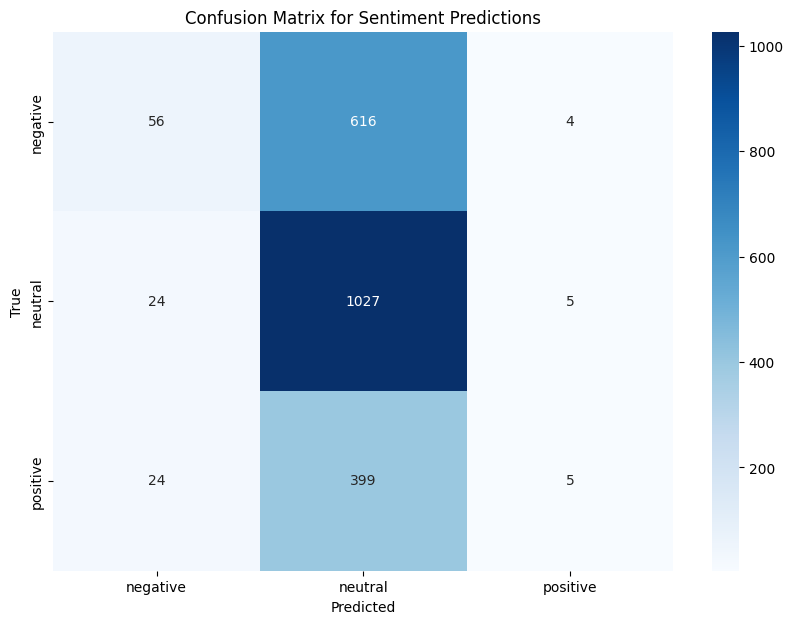

In [117]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sentiment_cm = confusion_matrix(sentiment_labels, sentiment_preds)
emotion_cm = confusion_matrix(emotion_labels, emotion_preds)

sentiment_classes = ['negative', 'neutral', 'positive']
emotion_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

plt.figure(figsize=(10,7))
sns.heatmap(sentiment_cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.title('Confusion Matrix for Sentiment Predictions')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

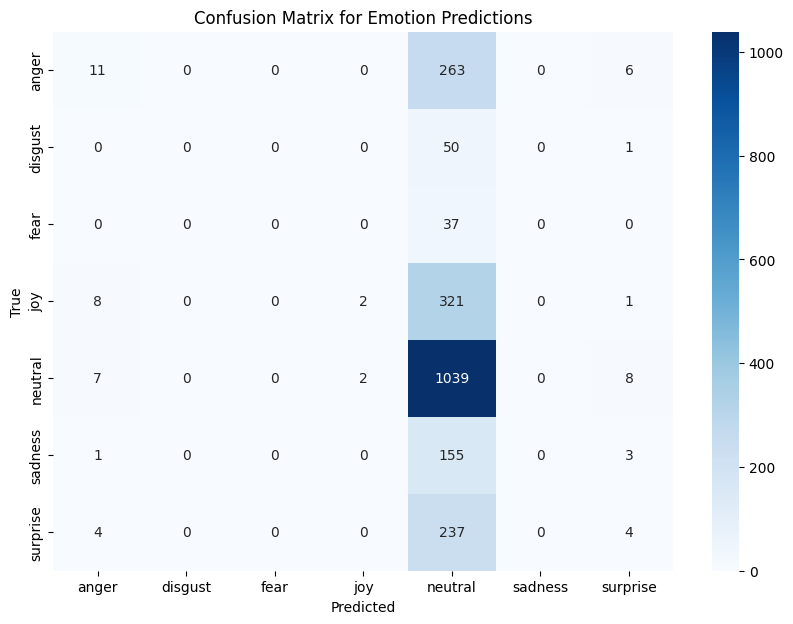

In [115]:
plt.figure(figsize=(10,7))
sns.heatmap(emotion_cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.title('Confusion Matrix for Emotion Predictions')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()